In [1]:
import math
import os
from pathlib import Path

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.feature import local_binary_pattern
from scipy.signal import gaussian
from scipy.signal import argrelextrema
from PIL import Image
from PIL.TiffTags import TAGS

# Helper functions

Implement any commonly used functions here.

In [2]:
def my_imshow(rows, cols, images, cmap='gray'):
    """
    This function displays images in a (rows x cols) grid.

    Parameters:
    rows (int): The number of rows in the grid of subplots.
    cols (int): The number of columns in the grid of subplots.
    images (list): A list of images to display row by row on the grid.
    cmap (string): Custom colur map for imshow(). Default: 'gray'

    Returns:
    No return value.
    """
    # Handle boundary conditions
    if len(images) > rows * cols:
        raise Exception('Number of images passed exceeds dimensions of grid')
    
    subfigs = []
    fig = plt.figure(figsize = (cols * 7, rows * 7))

    # Add subplots into the grid
    for i in range(rows):
        for j in range(cols):
            subfigs.append(fig.add_subplot(rows, cols, i * cols + j + 1))

    # Show images on the subplots created
    for i in range(len(images)):
        if cmap == 'gray':
            subfigs[i].imshow(images[i], cmap='gray', vmin=0, vmax=255)
        else:
            subfigs[i].imshow(images[i], cmap=cmap)

In [3]:
def write_tiff(tiff_template, dest_path, img):    
    """
    This function saves an input image as a TIFF image with metadata.

    Parameters:
    tiff_template (TIFF image): A sample TIFF image whose metadata is used as a template.
    dest_path (string): Output path at which the TIFF image is to be saved.
    img (np.ndarray): A histogram thresholded image from the dataset.

    Returns:
    No return value.
    """
    out = Image.fromarray(img)
    out.save(dest_path, tiffinfo = tiff_template.tag_v2)

In [30]:
def get_tiff_dict(path):
    """
    This function finds all sub-directories of path containing .tiff files

    Parameters:
    path (string): Parent directory to search for .tiff files.

    Returns:
    tiff_dirs (dict): A dictionary in which key: sub-directory, value: list of all .tiff files within the sub-directory
    """
    # Get the paths of all .tiff files in the sub-directories of path
    tiff_files = Path(path).rglob('*.tiff')
    tiff_dirs = {}

    # Form a list of tiff files within the same directory and add it
    # to the dict tiff_dirs with the directory path as key
    for tiff_file in tiff_files:
        tiff_file = str(tiff_file)
        if tiff_file.split('/')[-1][0] == '.':
            continue

        tiff_dir = '/'.join(tiff_file.split('/')[: -1])
        if tiff_dir in tiff_dirs.keys():
            tiff_dirs[tiff_dir].append(tiff_file)
        else:
            tiff_dirs[tiff_dir] = [tiff_file]
    
    return tiff_dirs

def normalize(img):
    """
    This function normalizes the input image using cv2.equalizeHist() to improve contrast

    Parameters:
    img (np.ndarray): The input image to normalize

    Returns:
    The normalized image
    """
    return cv2.equalizeHist(img)

# Global variables

In [5]:
# Define global variables used further in the notebook
dataset_root = '../data/'
datasets = ['s_o5', 's_o75', 's_1', 's_1o25', 's_1o5', 's_1o75', 's_2', 's_3']

# Histogram thresholding foreground segmentation

This method to segment foreground honeycomb from the background worked best. The method is implemented as follows:
* Get the histogram for the image
* Remove count of black pixels as they are the highest and not relevant to our task
* After removing black pixels, the tallest peak corresponds to background as 88.9% of pixels in the image corresponds to background (air).
* Make all the pixels corresponding to the left of this peak black using a second derivative based heuristic of the image histogram to find the optimum threshold value. This effectively removing background.
* Generate a mask of the foreground generated in the previous step
* Open and dilate the mask to remove noise and make honeycomb structures clear

In [6]:
def get_hist_fg(img):
    """
    This function computes the foreground mask for a single unprocessed dataset image.

    Parameters:
    img (np.ndarray): A unprocessed image from the dataset.

    Returns:
    mask (np.ndarray): Foreground mask (excludes air pixels).
    hist (np.ndarray): Histogram of the image.
    start (int): Foreground threshold pixel intensity.
    """
    # Gaussian blur to reduce image noise
    blurred_img = cv2.GaussianBlur(img, (7, 7), 0)

    # Calculate histogram of image
    hist = cv2.calcHist([blurred_img], [0], None, [256], [0,256])
    hist = np.squeeze(hist)
    hist[0] = 0

    # Find the pixel intensity (x-value) corresponding to the highest peak
    # The pixel-intensities falling under this peak correspond to air
    peak = np.argmax(hist)
    
    # Heuristic to find the pixel-intensity corresponding to the right-side base of the peak
    start = peak + 3
    derivative = np.gradient(hist)
    slope = derivative[start]
    
    for i in range(peak + 3, 256):
        if derivative[i] / slope < 0.025:
            break
        start += 1

    # Morphological operations to remove noise and enhance the foreground
    mask = np.where(img > start, 255, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    return mask, hist, start

### Driver function for histogram thresholding

In [7]:
def histogram_thresh(path):
    """
    This is a driver function to compute the foreground of unprocessed dataset images using get_hist_fg().
    This function also computes the average proportion of air pixels in the dataset.

    Parameters:
    path (string): Dataset path.

    Returns:
    pd.DataFrame: Creates a pd.DataFrame with a column containing the proportion of air pixels, indexed by the dataset name.
    """
    air_pixels_proportion_dict = {}
    air_pixels_proportion_list = []

    tiff_file_path =  path + '/tiff'
    tiff_files = get_tiff_dict(tiff_file_path)

    hist_solution_path = f'../data/{path.split(os.path.sep)[-1]}/hist_threshold/'
    
    # Create the output directory if it doesn't exist already
    if not os.path.isdir(hist_solution_path):
        os.makedirs(hist_solution_path)

    if not os.path.isdir(f'{hist_solution_path}/tiff/'):
        os.makedirs(f'{hist_solution_path}/tiff/')

    tiff_template = Image.open(tiff_files[tiff_file_path][0])
    temp_img = cv2.imread(tiff_files[tiff_file_path][0], cv2.IMREAD_GRAYSCALE)
    out = cv2.VideoWriter(hist_solution_path + path.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))

    print('Begin computing foreground of ' + path)
    for file in tqdm(sorted(tiff_files[tiff_file_path])):
        # Read a dataset image
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        # Call the histogram foreground thresholding function
        mask, hist, thresh = get_hist_fg(img)
        masked_image = cv2.bitwise_and(img, mask)

        ### Compute the average proportion of air pixels in the dataset
        total_pixels = img.shape[0] * img.shape[1]
        black_pixels = img[img == 0].shape[0]
        foreground_pixels = mask[mask > 0].shape[0]
        air_pixels = total_pixels - black_pixels - foreground_pixels
        air_pixels_proportion = air_pixels / (total_pixels - black_pixels)
        air_pixels_proportion_list.append(air_pixels_proportion)

        # Save the thresholded image as a TIFF image
        tiff_image = cv2.imread(file, -1)
        tiff_masked = cv2.bitwise_and(tiff_image, (mask > 0).astype(np.uint16) * 0xffff)
        write_tiff(tiff_template, f'{hist_solution_path}/tiff/{file.split(os.path.sep)[-1]}', tiff_masked)

        # Add the thresholded image into the dataset video
        out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
    print('Finish computing foreground of ' + path)

    air_pixels_proportion_dict[path.split(os.path.sep)[-1]] = np.mean(air_pixels_proportion_list)
    out.release()

    return pd.DataFrame.from_dict(air_pixels_proportion_dict, orient = 'index', columns = ['AirProportion'])

In [91]:
# Placeholder to store the proporition of air pixels in each dataset
air_pixels_proportion_df_list = []

# Call histogram_thresh() on the required datasets
for dataset in datasets:
    if os.path.isdir(dataset_root + dataset):
        air_pixels_proportion_df_list.append(histogram_thresh(dataset_root + dataset))

# Create a single dataset containing the proportion of air pixels for all datasets
air_pixels_proportion_df = pd.concat(air_pixels_proportion_df_list)

Begin computing foreground of ../data/s_o5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2034/2034 [17:00<00:00,  1.99it/s]


Finish computing foreground of ../data/s_o5


In [92]:
air_pixels_proportion_df

,AirProportion
s_o5,0.843924


### Test the function `get_hist_fg()`:

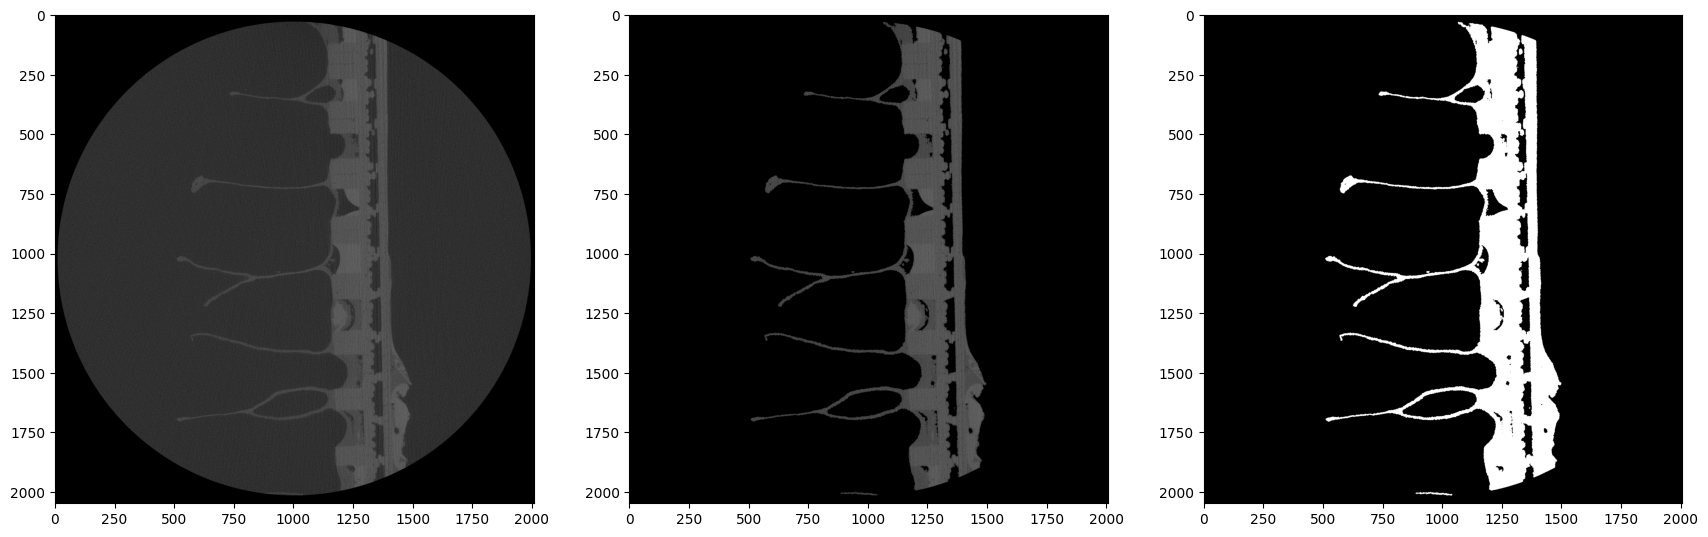

In [93]:
img = cv2.imread('../data/s_o5/tiff/0500.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_o75/tiff/0540.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1/tiff/0840.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o25/tiff/440.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o5/tiff/940.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o75/tiff/0621.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_2/tiff/0452.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_3/tiff/0630.tiff', cv2.IMREAD_GRAYSCALE)

mask, hist, thresh = get_hist_fg(img)
masked_image = cv2.bitwise_and(img, mask)
my_imshow(1, 3, [img, masked_image, mask])

## Plot the histogram of pixel intensities as a PMF

Essentially this plot is a PMF of the pixel intesnities and the threshold value used to subract out background noise is shown as a dashed line.
* X-axis - Pixel intensities
* Y-axis - Proportion

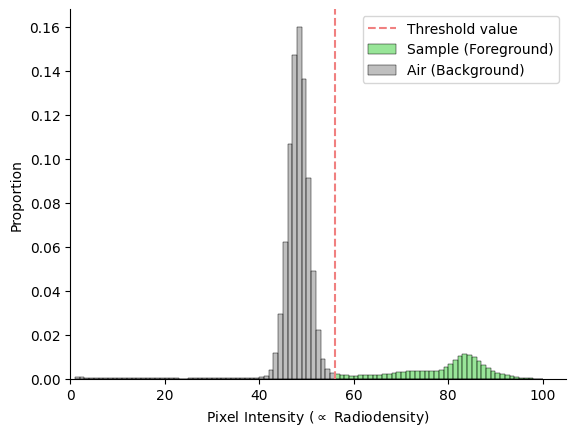

In [94]:
# Create a pd.DataFrame containing all pixel intensities in the blurred image
hist_fg_image_df = pd.DataFrame(cv2.GaussianBlur(img, (7, 7), 0).flatten(), columns=['PixelIntensity'])
mask = hist_fg_image_df.PixelIntensity < thresh

fig, axes = plt.subplots()

# Plot the histogram, with bars appropriately colored
ax = sns.histplot(data = hist_fg_image_df[hist_fg_image_df.PixelIntensity > 0], 
                  x = 'PixelIntensity', 
                  binwidth = 1, stat = 'proportion', 
                  hue=mask,
                  palette={True: 'gray', False: 'limegreen'},
                  element='bars', 
                  hue_order=[True, False],
                  legend=True, 
                  ax = axes)

# Mark the threshold value used for foreground segmentation
ax.axvline(x=thresh, c='lightcoral', ls='dashed', label = 'Threshold value')

ax.legend(['Threshold value', 'Sample (Foreground)', 'Air (Background)'])

ax.set_xlim(left = 0)
ax.set_xlabel(r'Pixel Intensity ($\propto$ Radiodensity)')

sns.despine()

# Save the figure
if not os.path.isdir('../data/figures'):
    os.makedirs('../data/figures')
ax.figure.savefig('../data/figures/histogram_segmentation.png', dpi=600)

# Plastic base filtering using kernel convolution

The following steps are done to segment plastic regions from images:
* Construct a 300x100 kernel in which the first half of the columns are all 1s and the second half of the columns are all -1s (or vice-versa depending on the relative positions of the honeycomb and the plastic starter in the dataset).
* Convolve this kernel over an image in the dataset. The kernel can be imagined to be a sliding window over the image, sliding over the image row by row.
* For each row of sliding the kernel over the image, identify the point where kernel convolution gives the maximum value. Due to the nature of the kernel design, this point in the row corresponds to the boundary of the plastic base and air.
* Dilate the identified boundary points obtained to fill the entire plastic region (dilation iterations is a parameter which needs to be tuned for each dataset).
* Obtain a bounding box for the dilated contour. This bounding box serves as the mask of plastic region in the slice.

The ideal values of parameters for each dataset can be found below.

In [95]:
def get_plastic_mask_sliding_window(img, left, dilation_iters):
    """
    This function computes the plastic base mask for a single histogram-thresholded dataset image.

    Parameters:
    img (np.ndarray): A histogram thresholded image from the dataset.
    left (bool): Switch to indicate the relative position of the honeycomb to the plastic base.
    dilation_iters (int): A tunable parameter to control the degree of dilation while creating the mask.

    Returns:
    np.ndarray: Mask to use to filter out the plastic base.
    """
    mask = np.zeros(img.shape)
    plastic_rect = np.zeros(img.shape)

    kernel_rows = 300
    kernel_cols = 100
        
    # Create the kernel to identify the boundary of the plastic base and air
    kernel = np.ones((kernel_rows, kernel_cols))
    if left:
        kernel[:, 50:] = -1
        col_range = np.arange(img.shape[1] - kernel_cols, 0, -10)
    else:
        kernel[:, :50] = -1
        col_range = np.arange(0, img.shape[1] - kernel_cols, 10)

    # Convolve the image with the kernel by using it as a sliding window
    for i in range(0, img.shape[0] - kernel_rows, kernel_rows):
        highest = 0
        highest_index = -1
        for j in col_range:
            # Heuristic to mark the boundary of the plastic base and air
            if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
                highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
                highest_index = j

        if left:
            mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
        else:
            mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Convolve the last strip that gets excluded above
    i = img.shape[0] - kernel_rows
    highest = 0
    highest_index = -1
    for j in col_range:
        # Heuristic to mark the boundary of the plastic base and air
        if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
            highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
            highest_index = j
    
    if left:
        mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
    else:
        mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Create a contour of the identified boundary
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour_wo_dilation = max(contours, key = cv2.contourArea)

    # Find the bounding box for this contour
    rect = cv2.minAreaRect(max_contour_wo_dilation)
    box = cv2.boxPoints(rect)
    plastic_box_wo_dilation = np.intp(box)

    # Dilate to create the final mask
    cv2.drawContours(plastic_rect, [plastic_box_wo_dilation], -1, (255, 255, 255), -1)
        
    dilated_result = cv2.dilate(plastic_rect.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)), iterations = dilation_iters)
    
    return dilated_result

### Mask out plastic base for o5x and o75x data

There is a different function for o5x because this dataset differs from previous datasets in the following ways:
* There is honey present below the starter
* A lot of wax is present on the above surface of the starter as well due to which the previous function (LBP TM) did not produce good results.

The method used to segment the plastic base for o5x and o75x is the same as earlier, but the kernel used as the sliding window differs to accomodate for the above peculariaties in the data for these cell sizes.

In [96]:
def get_plastic_mask_sliding_window_o5x(img, left, dilation_iters):
    """
    This function computes the plastic base mask for a single histogram-thresholded o5x or o75x image.
    We have a separate function for o5x and o75x because it is not as clean as the other datasets and needs special handling.

    Parameters:
    img (np.ndarray): A histogram thresholded image from the dataset.
    
    Returns:
    np.ndarray: Mask to use to filter out the plastic base.
    """
    mask = np.zeros(img.shape)
    plastic_rect = np.zeros(img.shape)

    kernel_rows = 300
    kernel_cols = 100
        
    # Create the kernel to identify the boundary of the plastic base and air
    kernel = np.ones((kernel_rows, kernel_cols))
    # o5x data
    kernel[:, 35:65] = -1
    if left:
        col_range = np.arange(img.shape[1] - kernel_cols, 0, -10)
    else:
        col_range = np.arange(0, img.shape[1] - kernel_cols, 10)

    # Convolve the image with the kernel by using it as a sliding window
    for i in range(0, img.shape[0] - kernel_rows, kernel_rows):
        highest = 0
        highest_index = -1
        for j in col_range:
            # Heuristic to mark the boundary of the plastic base and air
            if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
                highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
                highest_index = j

        if left:
            mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
        else:
            mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Convolve the last strip that gets excluded above
    i = img.shape[0] - kernel_rows
    highest = 0
    highest_index = -1
    for j in col_range:
        # Heuristic to mark the boundary of the plastic base and air
        if np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel) > highest:
            highest = np.sum(img[i: i + kernel_rows, j: j + kernel_cols] * kernel)
            highest_index = j
    
    if left:
        mask[i: i + kernel_rows, highest_index + 90: highest_index + 120] = 255
    else:
        mask[i: i + kernel_rows, highest_index: highest_index + 30] = 255

    # Create a contour of the identified boundary
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    max_contour_wo_dilation = max(contours, key = cv2.contourArea)

    # Find the bounding box for this contour
    rect = cv2.minAreaRect(max_contour_wo_dilation)
    box = cv2.boxPoints(rect)
    plastic_box_wo_dilation = np.intp(box)

    # Dilate to create the final mask
    cv2.drawContours(plastic_rect, [plastic_box_wo_dilation], -1, (255, 255, 255), -1)
    dilated_result = cv2.dilate(plastic_rect.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)), iterations = dilation_iters)
    
    return dilated_result

### Driver function to filter out the plastic base

In [97]:
def filter_out_plastic_base(path, left, iters):
    """
    Driver function to compute the plastic base masks for the dataset images

    Parameters:
    path (string): Path to the top level directory of the dataset.
    left (bool): Switch to indicate the relative position of the honeycomb to the plastic base.
    dilation_iters (int): A tunable parameter to control the degree of dilation while creating the mask.

    Returns:
    No return value.
    """
    tiff_file_path =  path + '/hist_threshold/tiff'
    tiff_files = get_tiff_dict(tiff_file_path)

    plastic_base_masked_solution_path = f'../data/{path.split(os.path.sep)[-1]}/plastic_base_masked/'

    # Create the output directory if it does not already exist
    if not os.path.isdir(plastic_base_masked_solution_path):
        os.makedirs(plastic_base_masked_solution_path)

    if not os.path.isdir(f'{plastic_base_masked_solution_path}/tiff/'):
        os.makedirs(f'{plastic_base_masked_solution_path}/tiff/')

    tiff_template = Image.open(tiff_files[tiff_file_path][0])
    temp_img = cv2.imread(tiff_files[tiff_file_path][0], cv2.IMREAD_GRAYSCALE)
    plastic_base_masked_out = cv2.VideoWriter(plastic_base_masked_solution_path + path.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))

    print('Begin segmenting plastic base of ' + path)
    for file in tqdm(sorted(tiff_files[tiff_file_path])):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        tiff_image = cv2.imread(file, -1)
        
        # Get plastic base mask from get_plastic_mask_sliding_window()
        dataset = path.split(os.path.sep)[-1]
        if dataset == 's_o5' or dataset == 's_o75':
            plastic_mask = get_plastic_mask_sliding_window_o5x(img, left, iters)
        else:
            plastic_mask = get_plastic_mask_sliding_window(img, left, iters)

        plastic_base_masked_image = cv2.bitwise_and(img, 255 - plastic_mask)
        tiff_plastic_base_masked = cv2.bitwise_and(tiff_image, ((255 - plastic_mask) > 0).astype(np.uint16) * 0xffff)
        write_tiff(tiff_template, f'{plastic_base_masked_solution_path}/tiff/{file.split(os.path.sep)[-1]}', tiff_plastic_base_masked)
        plastic_base_masked_out.write(cv2.cvtColor(plastic_base_masked_image, cv2.COLOR_GRAY2BGR))
    print('Finish segmenting plastic base of ' + path)
    
    plastic_base_masked_out.release()

In [98]:
plastic_base_mask_parameters = {
    's_o5': [True, 9], # o5x
    's_o75': [False, 7], # o75x
    's_1': [True, 14], # 1x
    's_1o25': [True, 13], # 1o25x
    's_1o5': [True, 13], # 1o5x
    's_1o75': [False, 13], # 1o75x
    's_2': [True, 9], # 2x
    's_3': [True, 18], # 3x
}

# Mask out the plastic base for the required datasets
for dataset in datasets:
    if os.path.isdir(dataset_root + dataset + '/hist_threshold'):
        filter_out_plastic_base(dataset_root + dataset, plastic_base_mask_parameters[dataset][0], plastic_base_mask_parameters[dataset][1])

Begin segmenting plastic base of ../data/s_o5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2034/2034 [48:18<00:00,  1.43s/it]


Finish segmenting plastic base of ../data/s_o5


### Test the function `get_plastic_mask_sliding_window()`

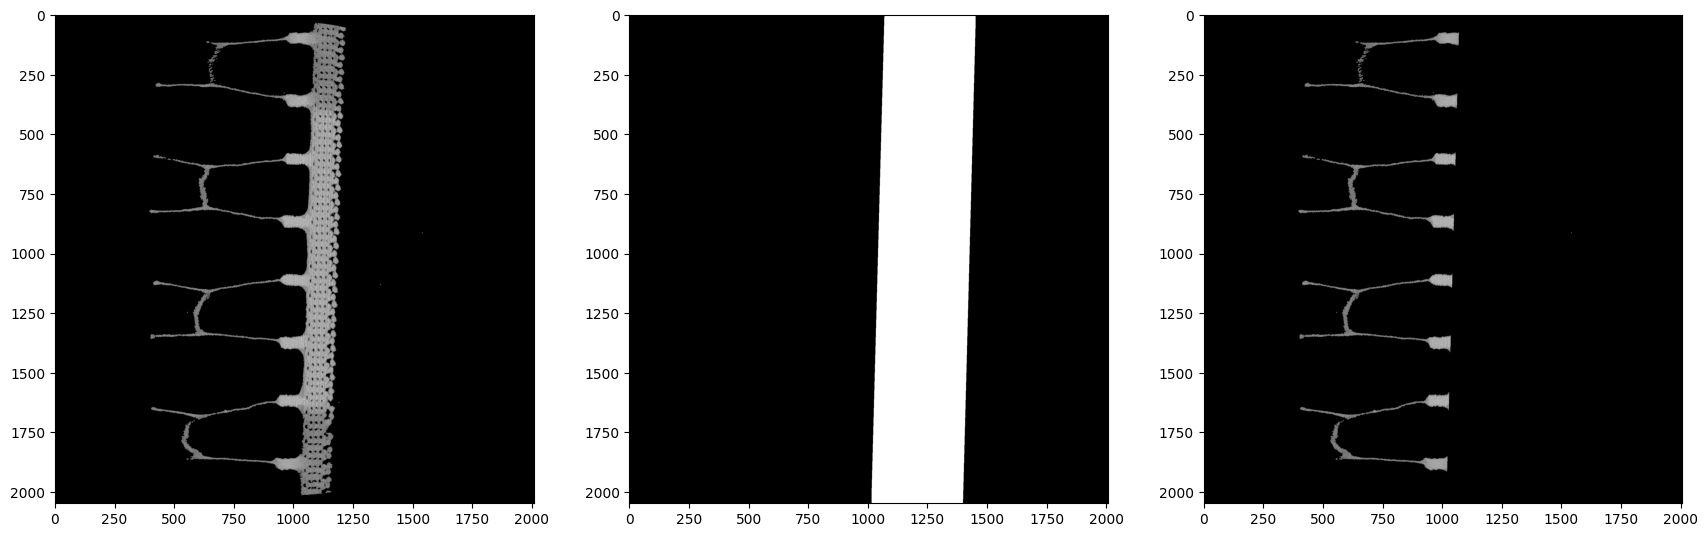

In [20]:
img = cv2.imread('../data/s_1/hist_threshold/tiff/0125.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o25/hist_threshold/tiff/0380.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o5/hist_threshold/tiff/0340.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o75/hist_threshold/tiff/0212.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_2/hist_threshold/tiff/0532.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_3/hist_threshold/tiff/0950.tiff', cv2.IMREAD_GRAYSCALE)

plastic_mask = get_plastic_mask_sliding_window(img, True, 14)
plastic_base_masked_image = cv2.bitwise_and(img, 255 - plastic_mask)
my_imshow(1, 3, [img, plastic_mask, plastic_base_masked_image])

### Test the function `get_plastic_mask_sliding_window_o5x()`

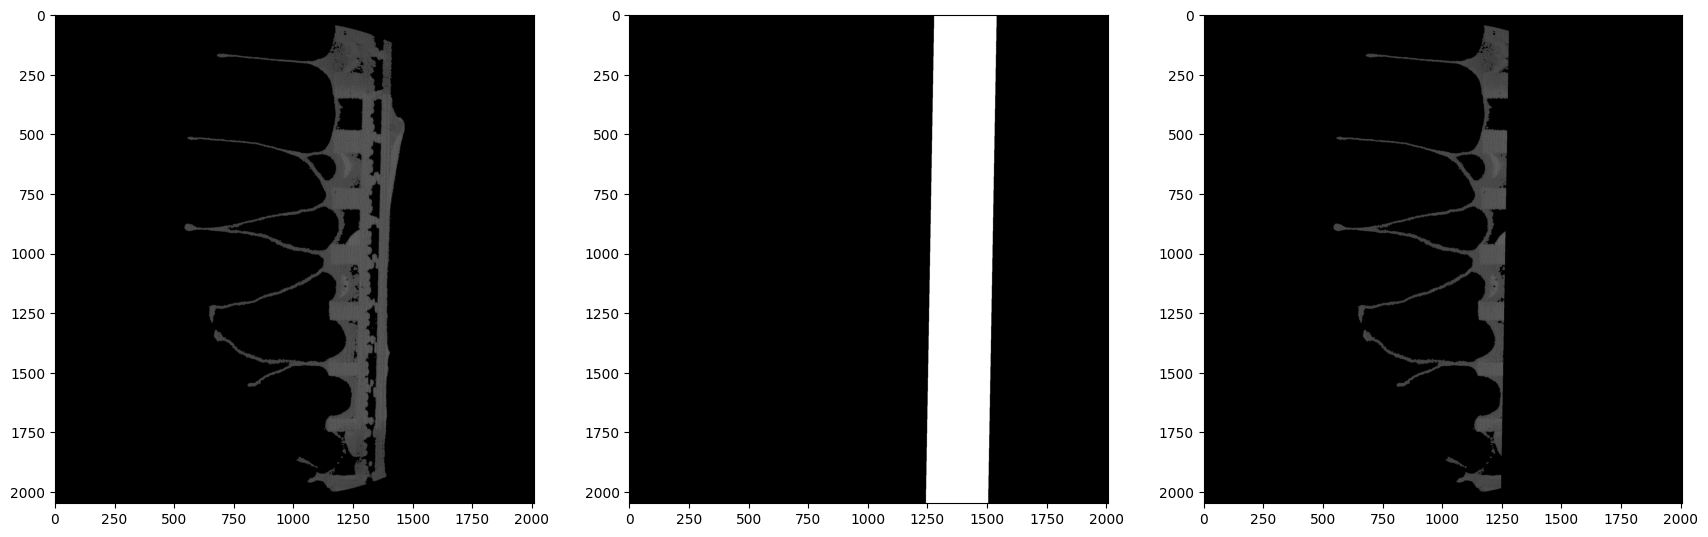

In [101]:
img = cv2.imread('../data/s_o5/hist_threshold/tiff/0149.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_o75/hist_threshold/tiff/0440.tiff', cv2.IMREAD_GRAYSCALE)

plastic_mask = get_plastic_mask_sliding_window_o5x(img, True, 9)
plastic_base_masked_image_o5x = cv2.bitwise_and(img, 255 - plastic_mask)

my_imshow(1, 3, [img, plastic_mask, plastic_base_masked_image_o5x])

# Segment plastic cell edges

In [102]:
def segment_plastic_cell_edges(img, sigma, length):
    """
    This function finds and segments the plastic cell edges for an input image where the plastic base is removed.
    The image histogram is smoothed and its minima are found to identify the segmenatation threshold.

    Parameters:
    img (np.ndarray): A histogram thresholded image from the dataset.
    sigma (float): Sigma for the Gaussian convolution kernel.
    length (int): Length of Gaussian convolution kernel.
    
    Returns:
    mask (np.ndarray): Mask to use to filter out the plastic base.
    curve (np.ndarray): A 1-d numpy array containing the Gaussian smoothed histogram.
    threshold (int): Segmentation threshold for plastic cell edges.
    """
    norm = normalize(img)
    blurred_img = cv2.GaussianBlur(norm, (3, 3), 0)

    # Form the Gaussian smoothing kernel
    kernel = gaussian(length, sigma)
    kernel /= np.sum(kernel)

    # Calculate the histogram of the blurred image
    hist = cv2.calcHist([blurred_img[blurred_img > 0]],[0],None,[256],[0,256])
    hist = np.squeeze(hist)

    # Smooth the image histogram with a Gaussian kernel
    curve = np.convolve(hist, kernel, 'same')

    # Compute the minima of the smoothed image histogram and identify the threshold value
    minima = argrelextrema(curve, np.less)[0]
    threshold = minima[-1]
    # Check if minimum returned is a false positive
    if curve[threshold] > curve[threshold - 10] or curve[threshold] > curve[threshold + 10 if threshold + 10 < 256 else 255]:
        threshold = minima[-2]

    # Enhance the mask
    mask = np.where(norm > (threshold + 20), 255, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    
    return mask, curve, threshold

### o5x data

Plastic is segmented differently in o5x data as the previous algorithm fails due to the presence of irregular artefacts like wax and honey around the plastic cell edges.
* o5x data uses a simpler algorithm to find segment plastic regions.
* It is done by simple thresholding and morphological operations.

In [103]:
def segment_plastic_cell_edges_o5x(tiff_image):
    """
    This function finds and segments the plastic cell edges for a o5x dataset image where the plastic base is removed.
    We write a separate function for o5x becasue the dataset is not as clean and requires special handling.

    Parameters:
    tiff_image (np.ndarray): A histogram thresholded TIFF image from the o5x dataset.
    
    Returns:
    np.ndarray: Mask to use to filter out the plastic cell edges.
    """
    img = cv2.GaussianBlur(tiff_image, (5, 5), 0)

    mask = np.logical_and(img > 21000, img < 22500) * 255
    mask = mask.astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)

    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    valid_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 2000:
            valid_contours.append(contour)

    plastic_segments = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    plastic_segments = cv2.drawContours(plastic_segments, valid_contours, -1, (255, 255, 255), -1)
    plastic_segments = cv2.cvtColor(plastic_segments, cv2.COLOR_BGR2GRAY)
    plastic_segments = cv2.morphologyEx(plastic_segments, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))
    
    return plastic_segments

### Driver function to segment plastic edges

In [104]:
# Driver code to segment 'teeth' of plastic starter
def segment_plastic_cell_edges_driver(path, sigma = 4.0, length = 15):
    """
    Driver function to segment the plastic cell edges for the dataset images

    Parameters:
    path (string): Path to the top level directory of the dataset.
    sigma (float): Sigma for the Gaussian convolution kernel used in segment_plastic_cell_edges().
    length (int): Length of Gaussian convolution kernel used in segment_plastic_cell_edges().

    Returns:
    No return value.
    """
    tiff_file_path =  path + '/plastic_base_masked/tiff'
    tiff_files = get_tiff_dict(tiff_file_path)
        
    plastic_segment_solution_path = f'../data/{path.split(os.path.sep)[-1]}/plastic_segmented/'

    # Create the output directory if it does not exist already
    if not os.path.isdir(plastic_segment_solution_path):
        os.makedirs(plastic_segment_solution_path)
        
    if not os.path.isdir(f'{plastic_segment_solution_path}/tiff/'):
        os.makedirs(f'{plastic_segment_solution_path}/tiff/')

    # Initialize video writer
    tiff_template = Image.open(tiff_files[tiff_file_path][0])
    temp_img = cv2.imread(tiff_files[tiff_file_path][0], cv2.IMREAD_GRAYSCALE)
    out = cv2.VideoWriter(plastic_segment_solution_path + path.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))

    print('Begin segmenting plastic cell edges of ' + path)
    for file in tqdm(sorted(tiff_files[tiff_file_path])):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        tiff_image = cv2.imread(file, -1)

        dataset = path.split(os.path.sep)[-1]
        if dataset == 's_o5':
            plastic_segments_mask = segment_plastic_cell_edges_o5x(tiff_image)
        else:
            plastic_segments_mask, curve, threshold = segment_plastic_cell_edges(img, sigma, length)
            
        masked_image = img
        masked_image[plastic_segments_mask == 255] = 255
        
        tiff_masked = tiff_image
        tiff_masked[plastic_segments_mask == 255] = 0xffff
        
        write_tiff(tiff_template, f'{plastic_segment_solution_path}/tiff/{file.split(os.path.sep)[-1]}', tiff_masked)
        out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
    print('Finish segmenting plastic cell edges of ' + path)

    out.release()

In [110]:
# Segment the plastic cell edges for the required datasets
for dataset in datasets:
    if os.path.isdir(dataset_root + dataset + '/plastic_base_masked'):
        segment_plastic_cell_edges_driver(dataset_root + dataset)

Begin segmenting plastic cell edges of ../data/s_o5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2034/2034 [25:04<00:00,  1.35it/s]

Finish segmenting plastic cell edges of ../data/s_o5


### Test function `segment_plastic_cell_edges()`

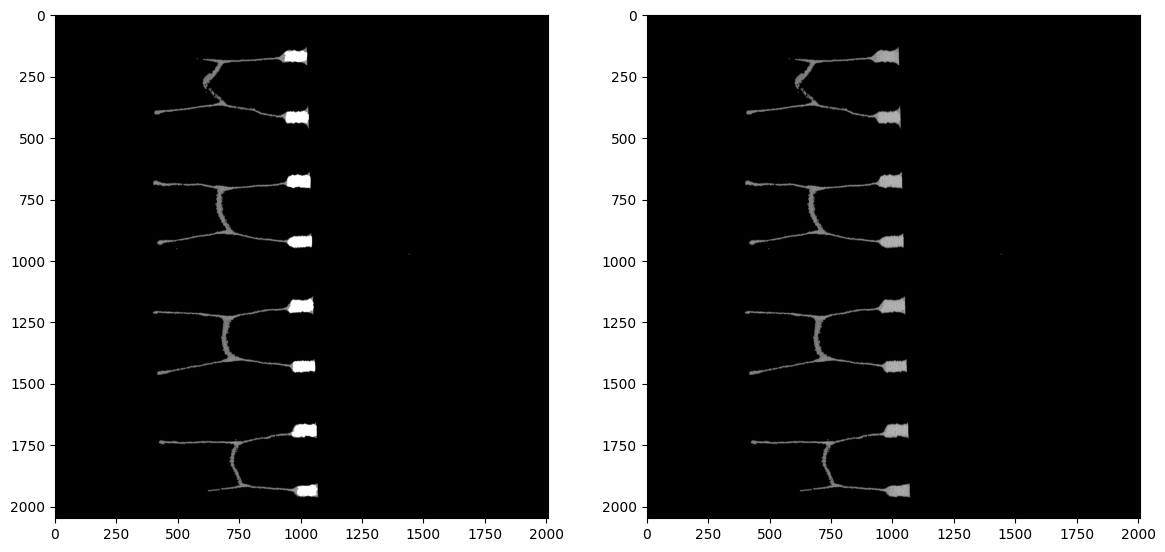

In [109]:
# img = cv2.imread('../data/s_o75/plastic_base_masked/tiff/0275.tiff', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('../data/s_1/plastic_base_masked/tiff/0140.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o25/plastic_base_masked/tiff/0840.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o5/plastic_base_masked/tiff/0410.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_1o75/plastic_base_masked/tiff/0541.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_2/plastic_base_masked/tiff/0367.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv2.imread('../data/s_3/plastic_base_masked/tiff/0050.tiff', cv2.IMREAD_GRAYSCALE)

mask, curve, threshold = segment_plastic_cell_edges(img, 4, 15)
masked_image = img.copy()
masked_image[mask == 255] = 255

my_imshow(1, 2, [masked_image, img])

### Test function `segment_plastic_cell_edges_o5x()`

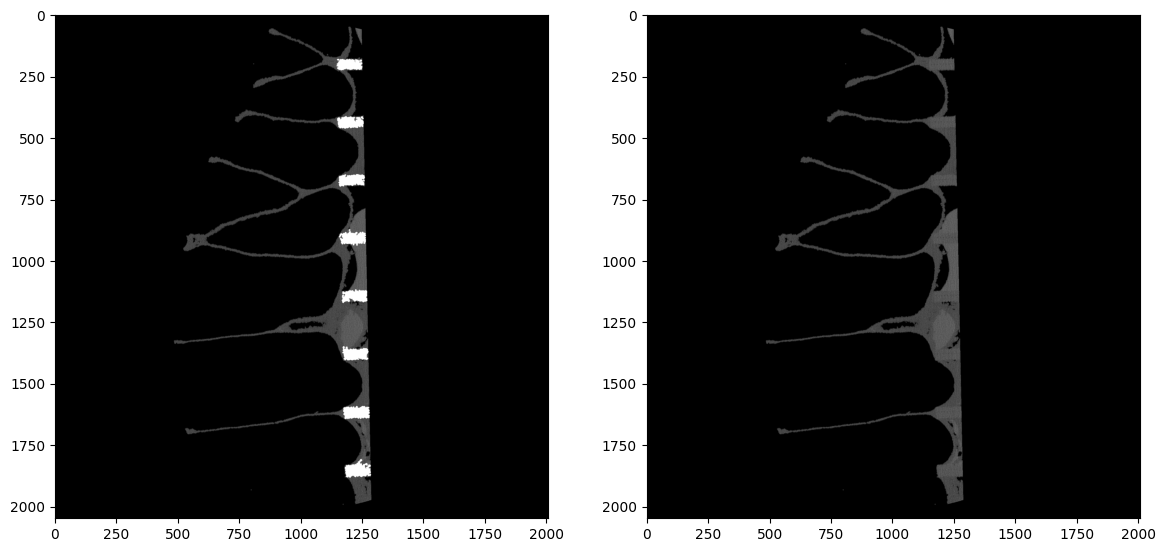

In [111]:
path = '../data/s_o5/plastic_base_masked/tiff/0415.tiff'

img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
tiff_image = cv2.imread(path, -1)

plastic_mask = segment_plastic_cell_edges_o5x(tiff_image)
masked_image = img.copy()
masked_image[plastic_mask == 255] = 255

my_imshow(1, 2, [masked_image, img])

## Plot for plastic cell edge segmentation

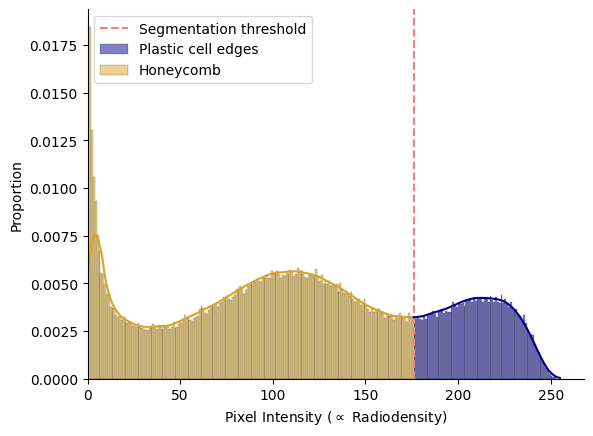

In [112]:
masked_image, curve, threshold = segment_plastic_cell_edges(img, 4, 15)
# Form a DataFrame for the input image
plastic_cell_edges_segmentation_image_df = pd.DataFrame(cv2.GaussianBlur(normalize(img), (3, 3), 0).flatten(), columns=['PixelIntensity'])
df_mask = plastic_cell_edges_segmentation_image_df.PixelIntensity < threshold
curve /= curve.sum()
# Form a DataFrame for the curve
plastic_cell_edges_segmentation_curve_df = pd.DataFrame(zip(range(len(curve)), curve), columns=['PixelIntensity', 'GaussianSmoothedHistogram'])
plastic_cell_edges_segmentation_curve_df['Segment'] = 0
plastic_cell_edges_segmentation_curve_df.loc[plastic_cell_edges_segmentation_curve_df.PixelIntensity >= threshold, 'Segment'] = 1

fig, axes = plt.subplots()

# Plot the histogram of pixel intensities in the input image, showing proportions
ax = sns.histplot(data = plastic_cell_edges_segmentation_image_df[plastic_cell_edges_segmentation_image_df.PixelIntensity > 0], x = 'PixelIntensity', binwidth = 1, stat = 'proportion', hue=df_mask, palette={True: 'goldenrod', False: 'darkblue'},
             element='bars', hue_order=[True, False], legend=True, ax = axes)
ax.axvline(x=threshold, c='lightcoral', ls='dashed', label = 'Segmentation threshold')
ax.legend(['Segmentation threshold', 'Plastic cell edges', 'Honeycomb'])#, title='Pixel intensity')

# Plot the Gaussian smoothed histogram used to find the threshold value
sns.lineplot(data=plastic_cell_edges_segmentation_curve_df, x='PixelIntensity', y='GaussianSmoothedHistogram', hue='Segment', palette={0: 'goldenrod', 1: 'darkblue'}, legend=None)

ax.set_xlim(left = 0)

ax.set_xlabel(r'Pixel Intensity ($\propto$ Radiodensity)')
sns.despine()

# Save the figure
if not os.path.isdir('../data/figures'):
    os.makedirs('../data/figures')
ax.figure.savefig('../data/figures/plastic_histogram_segmentation.png', dpi=600)